### Contents <a id="top">

#### [Introduction](#intro)
#### [Experimental design](#design)
#### [Import packages and setup muselsl](#setup)
#### [Shuffle sentences and time stimulus events](#shuffle)
#### [Present stimulus](#present)
#### [Preprocess data](#preprocess)
#### [Plot results](#plot)

-------

### Introduction <a id="intro">

<a href="https://www.researchgate.net/figure/N400-and-P600-Components-of-the-ERP_fig1_326606501"><img src="https://www.researchgate.net/profile/Patrick-Ledwidge/publication/326606501/figure/fig1/AS:652287580053505@1532528886461/N400-and-P600-Components-of-the-ERP.png" alt="N400 and P600 Components of the ERP." width="300px" style="float: right;"/></a>

In the current experiment, I attempt to measure the N400, an ERP-component usually elicited by an increased load on semantic processing. The N400 is characterized by a negativity typically observable around 400 ms after the occurrence of the stimulus, maximal in amplitude in the central-parietal areas, but otherwise broadly distributed over the scalp. The N400 is sensitive to infrequent as well as contextually unexpected words. Semantic priming (the previous presentation of semantically related words) has been shown to reduce its amplitude. For more details, see [the Wikipedia page for the N400 ERP-component](https://en.wikipedia.org/wiki/N400_(neuroscience)).

The current experiment examines the contextual aspect of the N400. I hypothesise that people in general tend to expect men and women to have jobs and demonstrate attitudes that are traditionally masculine or feminine, respectively. Therefore, sentences that communicate information deviating from these standards should elicit the N400 response due to difficulties in contextual processing. Several EEG studies have been conducted in search of a similar effect. To give a few examples, White et. al. (2009) have shown that word pairs inconsistent with gender stereotypes (such as *agressive woman*) elicit the N400, while Misersky et. al. (2017) found no such response to sentences describing a group of people, the gender of whom was incongruent with the grammatical gender of the noun referring to them.

---------

Misersky, J. (2017): *The effects of grammatical gender on reference processing in German: An ERP Study.* Nijmegen CNS, 12(1), 74-82. (Downloaded: [link](https://www.ru.nl/publish/pages/825831/julia_misersky_printversion.pdf))

White, K. R., Crites Jr, S. L., Taylor, J. H., & Corral, G. (2009): *Wait, what? Assessing stereotype incongruities using the N400 ERP component.* Social Cognitive and Affective Neuroscience, 4(2), 191-198. (Downloaded: [link](https://www.researchgate.net/publication/24185559_Wait_what_Assessing_stereotype_incongruities_using_the_N400_ERP_component))

Source of the figure: The Impact of Sports-Related Concussions on the Language System: A Case for Event-Related Brain Potentials - Scientific Figure on ResearchGate. (Available from: [link](https://www.researchgate.net/figure/N400-and-P600-Components-of-the-ERP_fig1_326606501))

#### [back to top](#top)

------

### Experimental design  <a id="design">

Sentences were presented word-by-word on a computer screen, with the following grammatical structure:

$The$ $<subject>$ $<adverb>$ $<predicate>$ $<\textit{possessive gender pronoun}>$ $<object>$.

Some of these sentences described men and women doing activities that are consistent with gender stereotypes, such as "*The doctor carefully prepared his tools.*" or "*The mother gently held her baby.*", while others purposefully violated such gender-specific expectations, e.g. "*The engineer tiredly cleaned her glasses.*" (engineering is perceived as a masculine occupation). I hypothesized that in case of these latter type of sentences, the N400 would be observable $250-500$ ms after the appearance of the pronoun revealing the subject's gender on screen.

7 members (3 women, 4 men) of Rajk College for Advanced studies participated in the study. All participants study economics, business or social sciences on BA or MA level. Their native language is Hungarian, but they are practised English speakers, which is important as the sentences were presented in English. (I couldn't have done the experiment in Hungarian due to the lack of gender-specific pronouns.)

For stimulus presentation, I used the [`PsychoPy`](https://www.psychopy.org/index.html) package. I recorded neural activity with the help of the [Muse headband](https://choosemuse.com/) and used the [`muse-lsl`](https://github.com/alexandrebarachant/muse-lsl) package to visualize the EEG-recording in real time to adjust the headband and stabilize the signal. The muse headband has 2 frontal and 2 temporal electrodes, which is not ideal to measure the centro-parietally concentrated N400, but it turned out to be adequate probably due to the widely extended nature of this ERP component. Nevertheless, due to the simplified technology of the Muse device and the potential noise disrupting the experimental conditions, the current study has its severe limitations.

#### [back to top](#top)

------

### Import packages and setup muselsl  <a id="setup">

In [ ]:
import psychopy
from psychopy import visual, core
from muselsl import view

In [3]:
import time, datetime
import glob

import numpy as np
import pandas as pd
import random

import matplotlib
from matplotlib import pyplot as plt

from scipy import signal
import scipy.io

#### record stream from command line

The EEG signal is recorded for $150$ seconds to fully encorporate the $\sim 104$ s duration of the stimulus presentation.

```muselsl stream -a 00:55:DA:B5:85:4C```

```muselsl record -d 150 -f "./MEGAsync/Academics/ELTE_CCNM/Semester 4./Programming/output/eeg_<subject>.csv"```

#### view real-time recording

In [ ]:
view(version=3, backend="nbAgg", figure='15x10')

#### [back to top](#top)

----------

### Shuffle sentences and time stimulus events  <a id="shuffle">

Sentences are presented in a random order that differs for each subject. Stimulus presentation time is adjusted to the framerate: each word is shown for 20 frames, with a break lasting 5 frames within and 100 frames between sentences.

In [2]:
with open("sentences.txt", "r") as f:
    sentences = f.read().split("\n")

In [3]:
def construct_stimulus(sentences, word_pres_dur=20, within_break=5, between_break=100):
    """
    Creates a dataframe, each row of which contain information about
    an individual frame during stimulus presentation.

    Parameters
    ----------
    sentences: list of strings
        The sentences to be presented.
    word_pres_dur: int, optional
        Specifies the duration of presentation for each word in frames. Default is 20.
    within_break: int, optional
        Specifies the duration of within-sentence breaks between words in frames. Default is 5.
    between_break: int, optional
        Specifies the duration of breaks between sentences in frames. Default is 100.

    Returns
    ----------
    out: pandas.core.frame.DataFrame
        Dataframe containing the following columns:
        - word: str, presented word
        - sentence: int, sentence ID
        - change: bool, indicates the appearance of a new word
        - time: None, column to store exact presentation times during stimulus presentation
    """

    shuffled_indices = random.sample(list(range(len(sentences))), len(sentences))

    return (
        pd.concat(
            [
                pd.concat(
                    [
                        pd.DataFrame([word] * word_pres_dur, columns=["word"]).append(
                            pd.DataFrame([{"word": ""} for k in range(within_break)])
                        )
                        for word in sentences[i].split(" ")
                    ]
                )
                .append(pd.DataFrame([{"word": ""} for k in range(between_break)]))
                .assign(sentence=i)
                for i in shuffled_indices
            ]
        )
        .reset_index(drop=True)
        .assign(change=lambda df: df["word"].ne(df["word"].shift()), time=None)
    )

#### [back to top](#top)

-------

### Present stimulus  <a id="present">

In [17]:
subject = "name" # set this variable to a new, unique value for each subject

In [18]:
stim_df = construct_stimulus(sentences)

In [ ]:
win = visual.Window([500, 500])
message = visual.TextStim(win)

# iterate over frames
for i, r in stim_df.iterrows():

    # set the stimulus to the next word
    if r["change"]:
        message.text = r["word"]

    # show the current word, unless it's a within-stimulus interval
    if r["word"]:
        message.draw()

    # record exact timing of each frame
    stim_df.loc[i, "time"] = time.time()

    # do not enter next iteration until the frame is refreshed
    win.flip()

win.close()
pd.DataFrame(stim_df).to_parquet(f"output/stim_data_{subject}.parquet")

#### [back to top](#top)

-----------

### Preprocess data  <a id="preprocess">

Below I read the EEG data of each subject and apply a bandpass filter to the signal from each recording channel with a passband between $0.5$ and $45$ Hz, to cover all typical EEG frequency components from delta to gamma and filter out the $50$ Hz signal coming from the European electric grid.

In [2]:
def filter_signal(recording, passband=(0.5, 45), sfreq=int(1 / 0.004)):

    sos = signal.butter(
        10,
        passband,
        btype="bandpass",
        fs=sfreq,
        output="sos",
    )
    return signal.sosfiltfilt(sos, recording)

In [4]:
subjects = [
    f.split("_")[1].replace(".csv", "") for f in sorted(glob.glob("output/*.csv"))
]

In [ ]:
eeg_recordings = {
    s: pd.read_csv(f"output/eeg_{s}.csv")
    .drop("Right AUX", axis=1)
    .pipe(
        lambda df: df.assign(
            **{
                f"filtered_{c}": filter_signal(df.loc[:, c].values)
                for c in df.columns[1:]
            }
        )
    )
    for s in subjects
}

Next, I read the stimulus data, and define `type_dict` that assigns a type to each sentence ID:
- 0: conventional relationship between the subject's profession and their gender
- 1: unconventional, surprising relationship

In [3]:
stimuli = {s: pd.read_parquet(f"output/stim_data_{s}.parquet") for s in subjects}

In [4]:
type_dict = {
    k: v
    for k, v in enumerate(
        [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]
    )
}

I combine all data into one unified dataframe by the following method. I extract the timing of pronouns in each sentence, and match them with the corresponding $500$ ms interval from the EEG-recording. Next, I average these intervals by sentence type and take the difference of the two averages for each subject individually. Finally, I average these differences for all subjects, and calculate their standard deviation as well.

In [5]:
channels = ["AF7", "AF8", "TP9", "TP10"]

In [8]:
results = {
    channel: pd.DataFrame(
        {
            s: stimuli[s]
            .loc[lambda df: df["word"].isin(["his", "her"]) & df["change"]]
            .assign(stim_type=lambda df: df["sentence"].apply(lambda s: type_dict[s]))
            .reset_index(drop=True)
            .pipe(
                lambda df: df.loc[:, ["stim_type"]].merge(
                    df.apply(
                        lambda r: eeg_recordings[s]
                        .loc[
                            lambda df2: (r["time"] <= df2["timestamps"])
                            & (df2["timestamps"] < r["time"] + 0.5),
                            f"filtered_{channel}",
                        ]
                        .reset_index(drop=True),
                        axis=1,
                    ),
                    left_index=True,
                    right_index=True,
                )
            )
            .groupby("stim_type")
            .mean()
            .sort_index(ascending=False)
            .diff()
            .loc[0, :]
            .iloc[:128]
            for s in subjects
        }
    )
    for channel in channels
}

-------

#### [back to top](#top)

### Plot results <a id="plot">

The plots below show the observed averaged differences for each recording channel, along with their standard deviations. It is clear from the figures that both temporal channels (especially TP9) show a significant negativity around $400$ ms after stimulus onset, which is characteristic for the N400.

**In conclusion, the current experiment confirms my hypothesis that the N400 is elicited by difficulties in semantic processing that are related to gender-specific stereotypes.** Increasing the sample size and drawing the stimulus from a larger set of sentences could improve the reliability of the results. Also, I categorized stimuli in an arbitrary, intuition-based manner. In the future, a more objective method could be used to determine the conventionality of each sentence presented to the subjects.

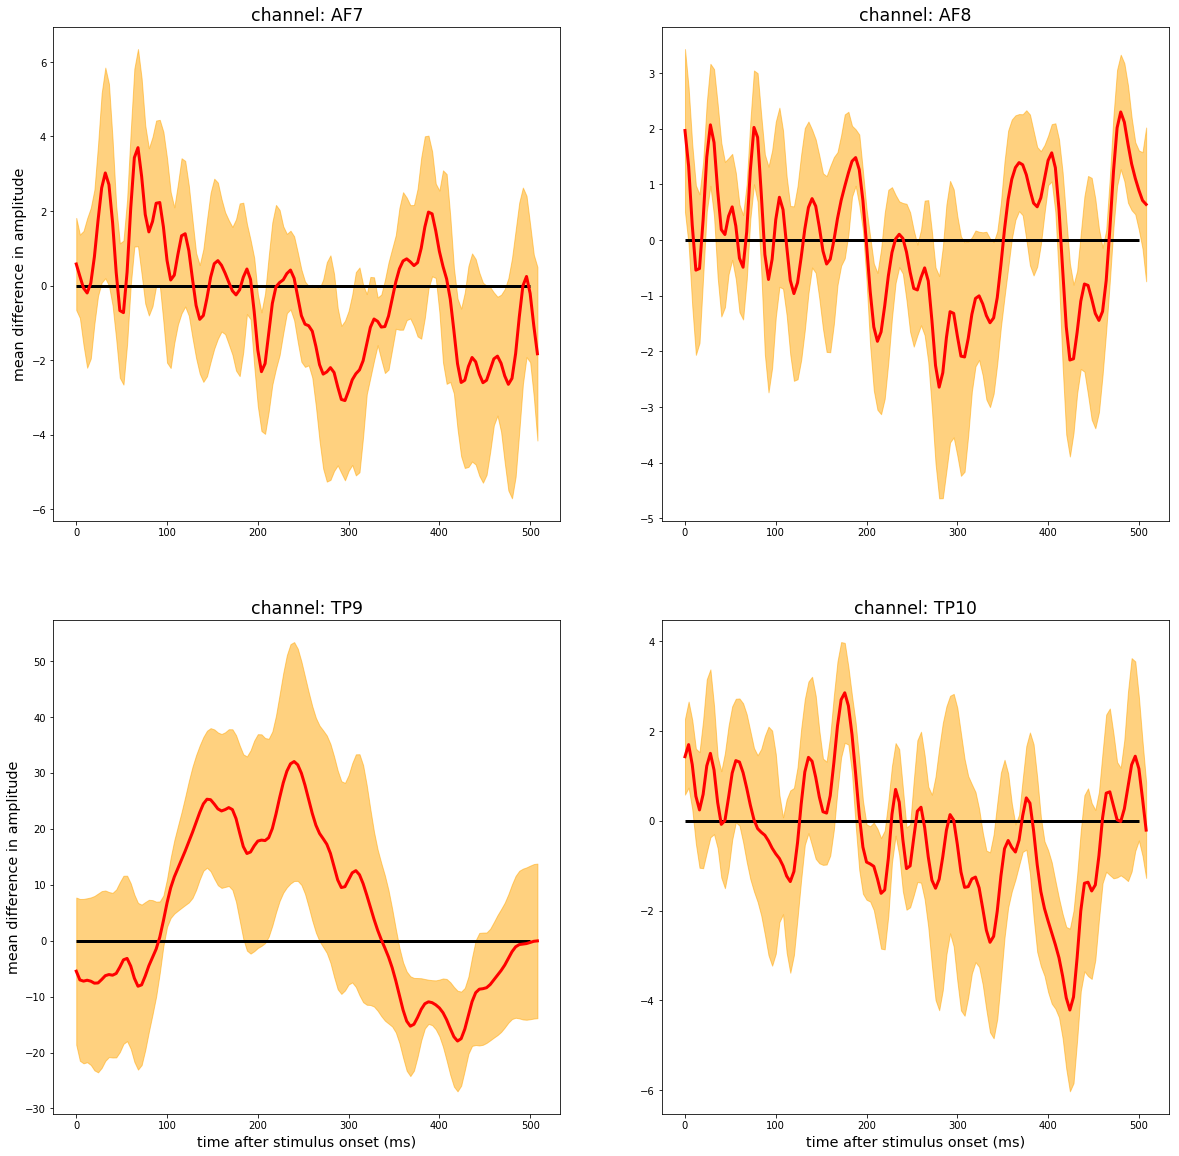

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, ax in enumerate(axes.flatten()):

    result = results[channels[i]]
    mean = result.mean(axis=1)
    se = result.std(axis=1) / np.sqrt(result.shape[1])
    x = np.arange(result.shape[0]) * 4

    ax.plot(x, mean, lw=3, c="red")
    ax.fill_between(
        x, (mean - se).values, (mean + se).values, alpha=0.5, color="orange"
    )
    ax.hlines(0, 0, 500, colors="black", lw=3)

    ax.set_title(f"channel: {channels[i]}", fontsize="xx-large")

    if i > 1:
        ax.set_xlabel("time after stimulus onset (ms)", fontsize="x-large")

    if i % 2 == 0:
        ax.set_ylabel("mean difference in amplitude", fontsize="x-large")

#### [back to top](#top)

----------